<a href="https://colab.research.google.com/github/Gblack98/PestVisionAI/blob/main/PEST_AI_VISION_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
emmarex_plantdisease_path = kagglehub.dataset_download('emmarex/plantdisease')

print('Data source import complete.')


In [ ]:
import os
import shutil
import random

# Pour la reproductibilité, si besoin (optionnel)
random.seed(42)

# Chemin vers le dataset d'origine et dossier de sortie
dataset_dir = '/kaggle/input/plantdisease/PlantVillage'
output_dir = '/kaggle/working/PlantVillage_split'



In [ ]:
# Créer les dossiers de split si ils n'existent pas déjà
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Récupérer la liste des classes (chaque dossier représente une classe)
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# Pour chaque classe, on split les images en 70% train, 20% val, 10% test
for class_name in classes:
    class_dir = os.path.join(dataset_dir, class_name)
    # Récupérer toutes les images (on suppose qu'elles sont directement dans le dossier)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Mélanger pour éviter les biais
    random.shuffle(images)
    total = len(images)
    train_end = int(0.7 * total)
    val_end = int(0.9 * total)  # 70% train, 20% validation (jusqu'à 90%), le reste test

    train_images = images[:train_end]
    val_images = images[train_end:val_end]
    test_images = images[val_end:]

    # Créer les sous-dossiers pour chaque classe dans les splits et copier les images
    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        target_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(target_dir, exist_ok=True)
        for img in split_images:
            src_path = os.path.join(class_dir, img)
            dst_path = os.path.join(target_dir, img)
            shutil.copy(src_path, dst_path)

print("Et voilà, le dataset  pour l'entraînement, la validation et le test !")


Et voilà, le dataset  pour l'entraînement, la validation et le test !


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Paramètres ---
IMG_SIZE = (224, 224)      # Taille standard pour de nombreux modèles (ex: ResNet50)
BATCH_SIZE = 32            # Taille du batch, à ajuster selon la RAM dispo
SEED = 42                  # Pour la reproductibilité

# --- Chemins vers les datasets pré-split ---
base_dir = '/kaggle/working/PlantVillage_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# --- Chargement des datasets avec image_dataset_from_directory ---
# Ces fonctions redimensionnent automatiquement les images à IMG_SIZE
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=False
)

# --- Data Augmentation ---
# On booste le dataset d'entraînement avec des transformations pour mieux généraliser.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),         # Flip horizontal aléatoire
    layers.RandomRotation(0.1),                # Petite rotation aléatoire
    layers.RandomZoom(0.1)                     # Zoom aléatoire
])

# --- Prétraitement spécifique au modèle ---
# Par exemple, pour ResNet50, il faut appliquer une normalisation propre à ce modèle.
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# --- Fonction de préparation du dataset ---
def prepare(ds, training=False):
    # Appliquer le prétraitement et, si en mode training, la data augmentation
    ds = ds.map(lambda x, y: (preprocess_input(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    # Cache et prefetch pour accélérer le pipeline
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Préparer chacun des datasets
train_ds = prepare(train_ds, training=True)
val_ds = prepare(val_ds, training=False)
test_ds = prepare(test_ds, training=False)

# --- Vérification de la pipeline ---
print("Datasets prétraités et prêts à être utilisés pour l'entraînement !")


Found 14441 files belonging to 15 classes.
Found 4127 files belonging to 15 classes.
Found 2070 files belonging to 15 classes.
Datasets prétraités et prêts à être utilisés pour l'entraînement !


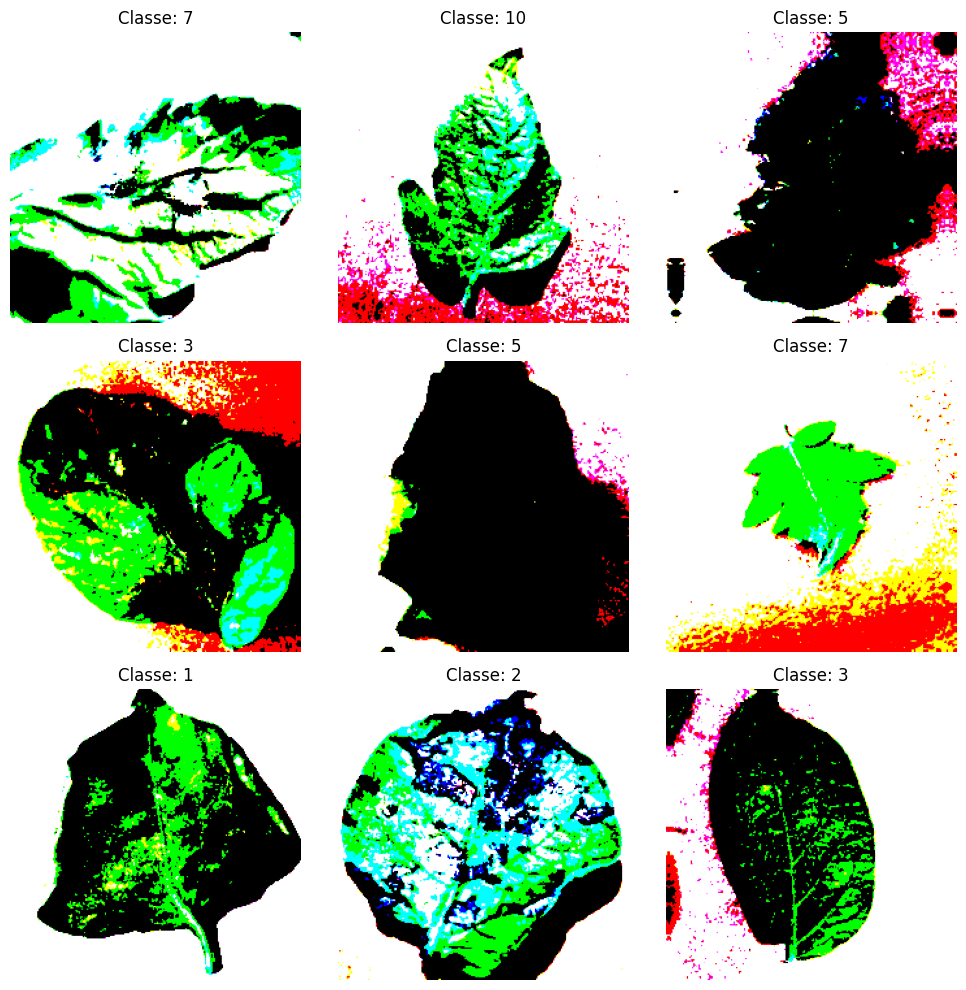

In [ ]:
import matplotlib.pyplot as plt

# Affichage d'un batch d'images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        # Les images sont déjà normalisées, on les affiche tel quel
        plt.imshow(images[i].numpy())
        plt.title(f"Classe: {labels[i].numpy().argmax()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


# Charger le dataset brut pour récupérer les class_names
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=SEED,
    shuffle=True
)

# Récupérer les noms des classes et leur nombre
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("Nombre de classes :", num_classes)


# --- Fonction de préparation du dataset ---
def prepare(ds, training=False):
    # Normalisation (scaling entre 0 et 1)
    ds = ds.map(lambda x, y: (x/255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Appliquer la préparation
train_ds = prepare(train_ds_raw, training=True)

# --- Construction du modèle ---
model = models.Sequential([
    # Couche d'entrée
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # --- Bloc 1 ---
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Bloc 2 ---
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Bloc 3 ---
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # --- Partie Classification ---
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Afficher le résumé du modèle
model.summary()


Found 14441 files belonging to 15 classes.
Nombre de classes : 15


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 51,679,279 (197.14 MB)

 Trainable params: 51,677,359 (197.13 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# --- Callbacks pour un entraînement optimal ---
callbacks = [
    # Arrêt précoce si la validation ne s'améliore plus pendant 5 epochs
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Sauvegarder le meilleur modèle (celui avec la meilleure val_loss)
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),

    # Réduire le learning rate si la performance stagne (facteur de 0.5 après 3 epochs sans amélioration)
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),

    # TensorBoard pour visualiser en temps réel (optionnel)
    TensorBoard(log_dir='./logs')
]

# --- Entraînement du modèle ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,            # Laisse tourner, on arrêtera si c'est trop !
    callbacks=callbacks,
    verbose=1
)



Epoch 1/50
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.5522 - loss: 1.4959
Epoch 1: val_loss improved from inf to 2335.60278, saving model to best_model.keras
452/452 ━━━━━━━━━━━━━━━━━━━━ 123s 220ms/step - accuracy: 0.5524 - loss: 1.4952 - val_accuracy: 0.0582 - val_loss: 2335.6028 - learning_rate: 0.0010
Epoch 2/50
  8/452 ━━━━━━━━━━━━━━━━━━━━ 1:10 159ms/step - accuracy: 0.7020 - loss: 0.8848

In [ ]:
# --- Visualisation rapide de l'historique d'entraînement ---
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
# Plot de la loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()

# Plot de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# --- Évaluation sur le dataset de test ---
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
# --- Génération de prédictions et création d'un rapport détaillé ---
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


In [ ]:
# --- Sauvegarde du modèle final ---
model.save("PEST_AI_VISION_1.h5")
print("\nModèle sauvegardé sous 'PEST_AI_VISION_1.h5'")
